In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date


import sys
lib_path = os.path.abspath(os.path.join(os.path.abspath(''), '../../functions/'))
sys.path.append(lib_path)
# need to append our functions dir to the path! 
import SD_NC_loading as sdl

In [2]:
filename = '../../R-code/data/Smoothin_and_groovin1664370045.0369315_DeltaCor_Jiang.csv'
filepath = os.path.abspath(os.path.join(os.path.abspath(''), filename))

In [3]:
# more work needed!!!!

def reloadDeltaCorr(filepath, keepFlags=0, onlyRrs=True, dateOnly=False):
    '''
    loads csv file generated by Dalin's R code into pandas df
    keepFlags selects which DeltaCor_flag should be accepted
        eg. keepFlags=[0, 1] will keep good data AND data with Oxygen aborption flag
        flags:
            0: good data
            1: Oxygen aborption at 760nm is too strong, may influence the Rrs shape
            2: out of the training range of the method
            3: extremely turbid, algae bloom, floating materials, high TSM waters
            4: negative results between 400-700 nm after delta correction
    onlyRrs drops all other columns except the output Rrs columns
    '''
    df = pd.read_csv(filepath)
    
    if type(keepFlags) is not list:
        keepFlags = [keepFlags]
    
    df = df[df['DeltaCor_flag'].isin(keepFlags)]
    
    if onlyRrs:
        df.drop(['Unnamed: 0', 'Rrs400', 'DeltaCor_method', 'DeltaCor_flag', 'RHW', 'Delta'], 
               axis=1, inplace=True)
        
    df.rename(columns={'Rrs400.1': 'Rrs400'}, inplace=True)
    #df['id'] = df.index
    df_long = pd.wide_to_long(df, 'Rrs', i='Date', j='Wavelength')
    
    df_long.sort_index(inplace=True)
    

    
    # currently dateOnly doesn't do what I want! need to rename the index! 

    df_long.index = pd.MultiIndex.from_arrays([pd.to_datetime(df_long.index.get_level_values(level=0)),
                                               df_long.index.get_level_values(level=1)])
    
    if dateOnly:
        # resample to daily 
        df_long = df_long.groupby([pd.Grouper(freq='1d', level=0)] + ['Wavelength']).median()
        df_long.index = pd.MultiIndex.from_arrays([pd.to_datetime(df_long.index.get_level_values(level=0)).date,
                                                   df_long.index.get_level_values(level=1)])
        df_long.index.names = ['Date', 'Wavelength']
    
    return df_long

In [4]:
dalecDaily = reloadDeltaCorr(filepath, dateOnly=True)

## Aug and Sept Daily DALEC Spectra

From my notes, I was aware of a an approx 2-week issue with the DALEC which I resolved via a power cycle. But it seems that following this 2 week period, the reflectance values drop considerably.

**Question:** is this a problem with the DALEC, or due to some change that has occurred as the bloom reduced? It appears that some reflectance peaks are still present, which suggests that the sensor is still working somewhat.. Perhaps we are now just seeing the bottom?

**Next step** - compare with Planet data to see if it matches!

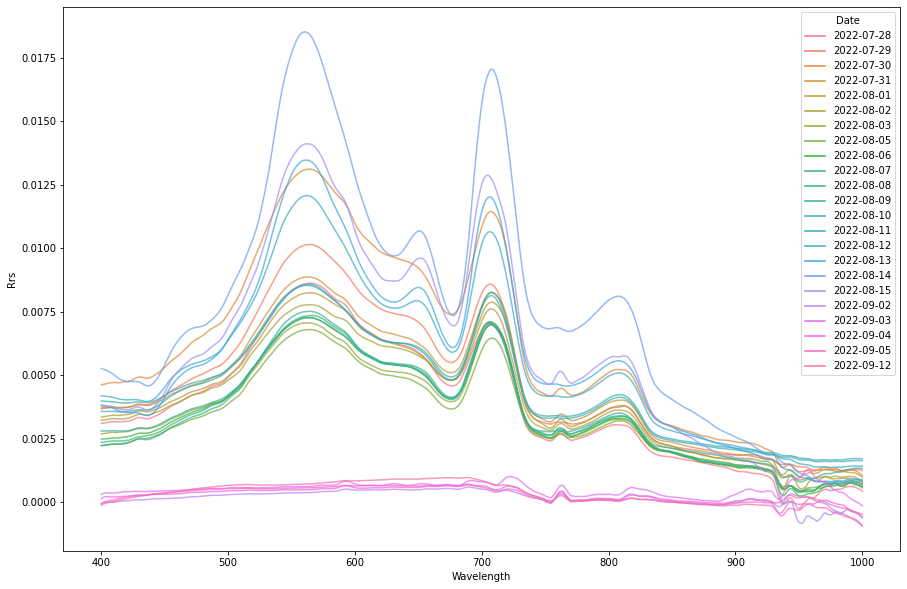

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(x='Wavelength', y='Rrs', hue='Date', data=dalecDaily, alpha=0.7, ax=ax)
#ax.set_ylim(-0.0005, 0.0012)
plt.show()

## Load SDs data

In [80]:
planet_dir = ('C:/Users/daa5/OneDrive - University of Stirling/PlanetData/' + 
              'Airthrey_aug-sept/airthreyAug-sept_psscene_analytic_8b_udm2/acolite_output/')

coord_deep = [56.146746528609306, -3.92285731543299] # this is perhaps a deeper part of the loch
coord_shallow = [56.14706637514574, -3.9234415013307387] # I think closer to where the DALEC actually is


SD_df = sdl.load_multiple_SDs(planet_dir, coord_shallow, dateOnly=True)

date skipping doesnae work if we only have 1 file!!!
date skipping doesnae work if we only have 1 file!!!
date skipping doesnae work if we only have 1 file!!!
...skipping duplicate date entry on 2022-08-11 (set skipSameDay=False to disable this)
date skipping doesnae work if we only have 1 file!!!
date skipping doesnae work if we only have 1 file!!!
date skipping doesnae work if we only have 1 file!!!
date skipping doesnae work if we only have 1 file!!!
...skipping duplicate date entry on 2022-09-10 (set skipSameDay=False to disable this)
date skipping doesnae work if we only have 1 file!!!
date skipping doesnae work if we only have 1 file!!!
date skipping doesnae work if we only have 1 file!!!
date skipping doesnae work if we only have 1 file!!!
date skipping doesnae work if we only have 1 file!!!
...skipping duplicate date entry on 2022-09-20 (set skipSameDay=False to disable this)
date skipping doesnae work if we only have 1 file!!!
...skipping duplicate date entry on 2022-09-20 (se

In [81]:
SD_df

rho_s_51_82
Date       Wavelength            
2022-08-10 444.0         0.003836
           492.0         0.003483
           533.0         0.006106
           566.0         0.008949
           612.0         0.006887
...                           ...
2022-09-24 566.0         0.010272
           612.0         0.009178
           666.0         0.008312
           707.0          0.01476
           866.0         0.024644

[80 rows x 1 columns]

In [82]:
# reset indexes to make my life easier!
dalecDaily.reset_index(inplace=True)
SD_df.reset_index(inplace=True)

In [83]:
SD_df['Date'] = SD_df['Date'].apply(pd.Timestamp.toordinal)
dalecDaily['Date'] = dalecDaily['Date'].apply(pd.Timestamp.toordinal)

In [84]:
# get min and max dates for consistent hue colouring

vmin = min([dalecDaily['Date'].min(), SD_df['Date'].min()])
vmax = max([dalecDaily['Date'].max(), SD_df['Date'].max()])
print((vmin, vmax))

(738364, 738422)


AttributeError: 'numpy.int64' object has no attribute 'month'

### Problem with September DALEC data

Okay, so this isn't the most readable plot in the world, but it is clear that the planet data from August is quite similar to the DALEC data, whereas the DALEC data from Sept looks nothing like it's planet counterpart.

Based on this, I'm definite that there was something up with the sensor. Possibly condensation or some kind of fouling on the sensor? Need to take some more measurements and see if these also have the same issue.

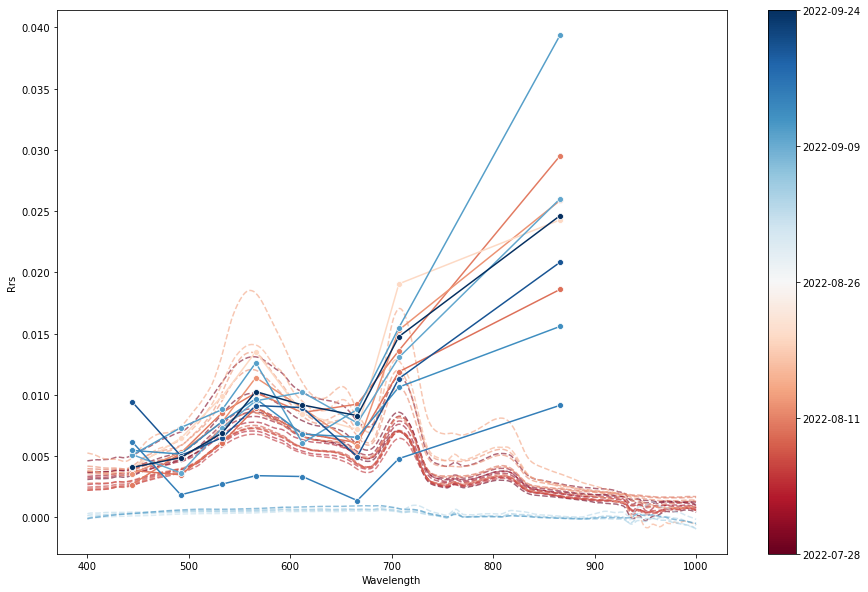

In [115]:


fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(x='Wavelength', y='Rrs', hue='Date', data=dalecDaily,
             alpha=0.6, ax=ax, hue_norm=(vmin,vmax), palette='RdBu', linestyle='--')
sns.lineplot(x='Wavelength', y='rho_s_51_82', hue='Date', data=SD_df,
             ax=ax, hue_norm=(vmin,vmax), palette='RdBu', marker='o')

norm = plt.Normalize(vmin, vmax)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.get_legend().remove()
tcks = np.linspace(vmin, vmax, 5)
#tcks = [vmin, vmin+((vmax-vmin)//2), vmax]
tck_labs = [str(datetime.fromordinal(int(tck)))[:10] for tck in tcks]

cbar = ax.figure.colorbar(sm, ticks=tcks)
cbar.ax.set_yticklabels(tck_labs)

plt.show()

## Now just messing

Try joining the data and creating some proper match up plots

In [117]:


# this isn't doing the conversion from DALEC wavebands to SD wavebands and so will be a bit off
DF = sdl.join_DALEC_SD_dfs(dalecDaily, SD_df, dropNA=True)

ValueError: len(left_on) must equal the number of levels in the index of "right"

In [ ]:
DF

NameError: name 'DF' is not defined

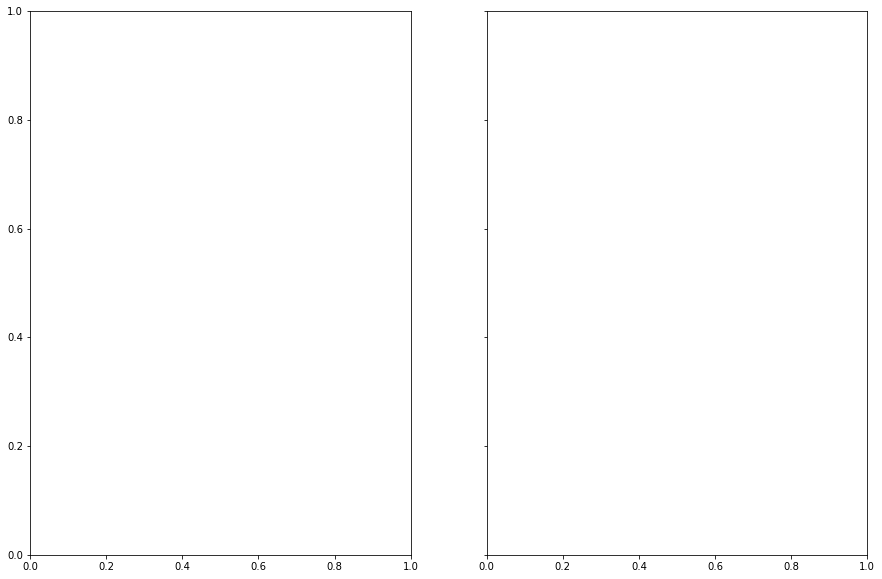

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10), sharey=True)

sns.lineplot(x='Wavelength', y='Rrs', hue='Date', data=DF, alpha=0.7, ax=ax[0])
sns.lineplot(x='Wavelength', y='rho_s_63_94', hue='Date', data=DF, alpha=0.7, ax=ax[1])

In [116]:
DF.reset_index(inplace=True)

NameError: name 'DF' is not defined

In [52]:
datetime.fromtimestamp(vmin.toordinal())

datetime.datetime(1970, 1, 9, 13, 6, 4)

In [53]:
vmin.toordinal()

738364

In [57]:
pd.to_datetime(SD_df['Date'])

0    2022-08-10
1    2022-08-10
2    2022-08-10
3    2022-08-10
4    2022-08-10
        ...    
75   2022-09-24
76   2022-09-24
77   2022-09-24
78   2022-09-24
79   2022-09-24
Name: Date, Length: 80, dtype: datetime64[ns]

In [104]:
tcks = [vmin, vmin+((vmax-vmin)//2), vmax]
tck_labs = [str(datetime.fromordinal(tck))[:10] for tck in tcks]
tck_labs

['2022-07-28', '2022-08-26', '2022-09-24']